# Data Preparation

In [ ]:
!pip install datasets

In [1]:
import datasets
import torch
import torch.optim as optim
import torch.nn as nn
import torchtext
from torchtext.vocab import vocab
import re
import matplotlib.pyplot as plt


Citation for dataset: Kennedy, C. J., Bacon, G., Sahn, A., & von Vacano, C. (2020). Constructing interval variables via faceted Rasch measurement and multitask deep learning: a hate speech application. arXiv preprint arXiv:2009.10277.

In [3]:
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary', split='train')
glove = torchtext.vocab.GloVe(name="6B", dim=50) 

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-f91f636a830ad73c
Reusing dataset parquet (/root/.cache/huggingface/datasets/parquet/ucberkeley-dlab--measuring-hate-speech-f91f636a830ad73c/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


The model takes as input a sequence of indices that represent a word from the vocabulary of the GloVe embeddings. Since there may be some unknowns, a custom vocab is created with the addition of an unknown token, "\<unk\>", and a padding token, "\<pad\>", to handle the variable length sequences. The embeddings of these two tokens is initialized as the zero vector.

In [4]:
glove_vocab = glove.stoi
glove_vocab['<unk>'] = 0
glove_vocab['<pad>'] = 0
data_vocab = vocab(glove_vocab, min_freq=0)
data_vocab.set_default_index(data_vocab['<unk>'])

data_vectors = torch.cat([glove.vectors, torch.zeros(1, glove.vectors.shape[1]), torch.zeros(1, glove.vectors.shape[1])])

In [5]:
unique_rows = dataset.unique('text')
def collect_unique(comment):
  """
  Return true for sequences that have not yet been seen in the dataset

  Parameters:
      comment - an example from the dataset to filter
  """
  if comment['text'] in unique_rows:
    unique_rows.remove(comment['text'])
    return True
  return False

def tokenize(comment):
  """
  Return an updated example row with columns for the tokenized text, the indices
  of the tokens using the vocab and a hate class based on the hate speech score

  Parameters:
      comment - an example from the dataset to process
  """
  #Uses a regular expression to split comments by spaces and punctuations
  comment['tokens'] = re.findall(r"[\w]+|[^\s\w]", comment['text'].lower())
  indexed = data_vocab.lookup_indices(comment['tokens'])
  comment['indices'] = indexed
  comment['hate_class'] = int(comment['hate_speech_score'] > 0)
  return comment

tokenized_dataset = dataset.filter(collect_unique).map(tokenize)

  0%|          | 0/136 [00:00<?, ?ba/s]

  0%|          | 0/39565 [00:00<?, ?ex/s]

Ensure that the train, validation and test set have examples of both hate speech and not hate speech by carefully splitting the tokenized dataset.

In [6]:
hate_dataset = tokenized_dataset.filter(lambda x: x['hate_class'] == 1)
not_hate_dataset = tokenized_dataset.filter(lambda x: x['hate_class'] == 0)

train_hate = hate_dataset.train_test_split(train_size=0.6, shuffle=True, seed=7)
valid_hate = train_hate.pop('test').train_test_split(train_size=0.5, shuffle=True, seed=7)
test_hate = valid_hate.pop('test')

train = not_hate_dataset.train_test_split(train_size=0.6, shuffle=True, seed=7)
valid = train.pop('test').train_test_split(train_size=0.5, shuffle=True, seed=7)
test = datasets.concatenate_datasets([valid.pop('test'), test_hate]).shuffle(seed=7)
train = datasets.concatenate_datasets([train['train'], train_hate['train']]).shuffle(seed=7)
valid = datasets.concatenate_datasets([valid['train'], valid_hate['train']]).shuffle(seed=7)

print(train)
print(valid)
print(test)

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

Dataset({
    features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target_gender_non_binary', 'target_

In [57]:
columns = ['indices', 'hate_class']
train.set_format(type='torch', columns=columns)
valid.set_format(type='torch', columns=columns)
test.set_format(type='torch', columns=columns)

# Batching

In [8]:
def collate_fn(examples):
  """
  Returns the batch of input sequences padded to the length of the longest sentence in the batch,
  a tensor of the labels of the batch sequences and a list of lengths of the sequences
  in the batch.

  This collate_function is used in a DataLoader to create batches from variable length sequences.

  Parameters:
      examples - a batch of indexed sequences from the dataset
  """
  sequences, lens = [], []
  for ex in examples:
    sequences.append(ex['indices'])
    lens.append(len(ex['indices']))
  labels = torch.stack([ex['hate_class'] for ex in examples])
  return torch.nn.utils.rnn.pad_sequence(sequences, padding_value=data_vocab['<pad>'], batch_first=True), labels, lens

# Training Code

In [9]:
def get_accuracy(model, data_set):
    """
    Return the accuracy of the model run on the provided dataset

    Parameters:
        model - the model to test
        dataset - the data to test the model on
    """
    data_loader = torch.utils.data.DataLoader(data_set, collate_fn=collate_fn, batch_size=512)
    model.eval()
    correct = 0
    total = 0
    for sents, labels, lens in data_loader:
      output = model(sents, lens) 
      pred = output.max(1, keepdim=True)[1] 
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += len(labels)

    return correct / total 
    
def train_model(model, train_data, valid_data, batch_size=32, weight_decay=0.0,
                learning_rate=0.001, num_epochs=7, checkpoint_path=None):
    """
    Train a the given model on the provided data and evaluate it against the validation
    set given the parameters. Plot the loss and training & validation accuracies of the
    model once training is complete.

    Parameters:
        model - the model to train
        train_data - the dataset to train the model on
        valid_data - the validation set to evaluate the model on
        batch_size - the batch size of the mini batches for training
        weight_decay - the weight decay for the optimizer
        learning_rate - the learning rate for the optimizer
        num_epochs - the number of epochs of training to run
        checkpoint_path - the location to store model weights while training
    """
    #training data
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, drop_last=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # loss function
    criterion = nn.CrossEntropyLoss()
    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0
    for epoch in range(num_epochs):
        for sents, labels, lens in train_loader:
            model.train()  # annotate model for training
            out = model(sents, lens)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses.append(float(loss))
            iters.append(n)
            n += 1

        # save the current training information
        if checkpoint_path is not None:
            torch.save(model.state_dict(), checkpoint_path.format(epoch))
        train_acc.append(get_accuracy(model, train_data))  # compute training accuracy
        val_acc.append(get_accuracy(model,valid_data))  # compute validation accuracy
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (epoch, loss, train_acc[-1], val_acc[-1]))
    
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(range(num_epochs), train_acc, label="Train")
    plt.plot(range(num_epochs), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

# Model

In [10]:
class HateDetectModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HateDetectModel, self).__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding.from_pretrained(data_vectors, freeze=False)
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)
    def forward(self, x, lens):
        x = self.embed(x)

        # pack sequences so rnn model does not consider padding in the sequences while training
        x = torch.nn.utils.rnn.pack_padded_sequence(x, lens, batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(x)
        out = torch.tanh(hidden)
        return self.fc(out).squeeze()

Overfittin

Epoch 0; Loss 0.665150; Train Acc 0.640625; Val Acc 0.639960
Epoch 1; Loss 2.175506; Train Acc 0.312500; Val Acc 0.370530
Epoch 2; Loss 4.837684; Train Acc 0.484375; Val Acc 0.438772
Epoch 3; Loss 1.138588; Train Acc 0.656250; Val Acc 0.641729
Epoch 4; Loss 2.218942; Train Acc 0.687500; Val Acc 0.624542
Epoch 5; Loss 0.912368; Train Acc 0.437500; Val Acc 0.383041
Epoch 6; Loss 1.251534; Train Acc 0.843750; Val Acc 0.592822
Epoch 7; Loss 0.343511; Train Acc 0.828125; Val Acc 0.631113
Epoch 8; Loss 0.343941; Train Acc 0.906250; Val Acc 0.627449
Epoch 9; Loss 0.173750; Train Acc 1.000000; Val Acc 0.607987
Epoch 10; Loss 0.075248; Train Acc 1.000000; Val Acc 0.578668
Epoch 11; Loss 0.046762; Train Acc 1.000000; Val Acc 0.560976
Epoch 12; Loss 0.032715; Train Acc 1.000000; Val Acc 0.559080
Epoch 13; Loss 0.018787; Train Acc 1.000000; Val Acc 0.558701
Epoch 14; Loss 0.011847; Train Acc 1.000000; Val Acc 0.559585


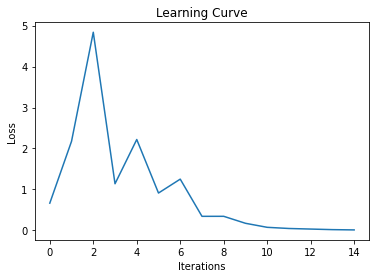

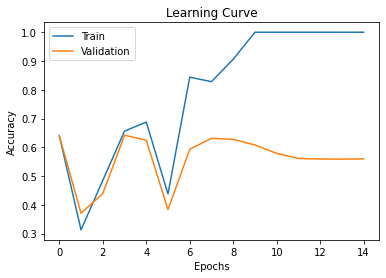

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5595854922279793


In [ ]:
batch = torch.utils.data.Subset(train, [i for i in range(64)])
overfit_model = HateDetectModel(50,128)
train_model(overfit_model, batch, valid, learning_rate=0.1, batch_size=64, num_epochs=15)

# Training

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Epoch 0; Loss 0.437527; Train Acc 0.797498; Val Acc 0.751548
Epoch 1; Loss 0.427164; Train Acc 0.847628; Val Acc 0.774927
Epoch 2; Loss 0.349873; Train Acc 0.866290; Val Acc 0.773158
Epoch 3; Loss 0.272282; Train Acc 0.878549; Val Acc 0.761279
Epoch 4; Loss 0.312217; Train Acc 0.894220; Val Acc 0.768229
Epoch 5; Loss 0.301307; Train Acc 0.911366; Val Acc 0.761153
Epoch 6; Loss 0.208639; Train Acc 0.922740; Val Acc 0.755087
Epoch 7; Loss 0.249199; Train Acc 0.933524; Val Acc 0.746493
Epoch 8; Loss 0.235130; Train Acc 0.931629; Val Acc 0.733856
Epoch 9; Loss 0.152940; Train Acc 0.945067; Val Acc 0.741312


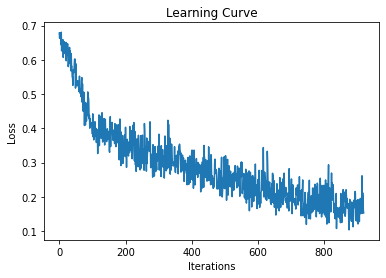

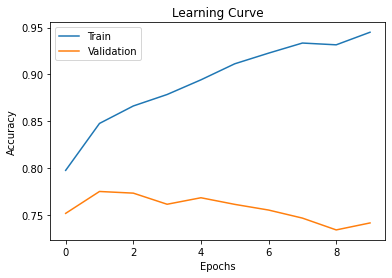

Final Training Accuracy: 0.9450669812115595
Final Validation Accuracy: 0.7413117654492607


In [ ]:
model = HateDetectModel(50,32)
train_model(model, train, valid, batch_size=256, num_epochs=10, checkpoint_path="/content/gdrive/My Drive/CSC413/Project/ckpt-{}.pk")

# Model Evaluation

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/Project/ckpt-2.pk'))
test_acc = get_accuracy(model, test)
print("Final Training Accuracy: {}".format(test_acc))

Final Training Accuracy: 0.7682587819054839


In [69]:
correct_example = test[4]['indices']
output = model(correct_example.unsqueeze(0), [len(correct_example)])
pred = output.max(0, keepdim=True)[1]
print("Prediction: ", pred)
print("Actual Class: ", test[4]['hate_class'])

Prediction:  tensor([1])
Class:  tensor(1)


In [71]:
wrong_example = test[0]['indices']

output = model(wrong_example.unsqueeze(0), [len(wrong_example)])
pred = output.max(0, keepdim=True)[1]
print("Prediction: ", pred)
print("Actual Class: ", test[0]['hate_class'])

Prediction:  tensor([1])
Actual Class:  tensor(0)


In [73]:
test.reset_format()
print("Correctly Classified: ", test[4]['text'])
print("Incorrectly Classified: ", test[0]['text'])

Correctly Classified:  Cowards Saudis knows very well that Iran is way too powerful and will roasts them like a chicken. They're playing under the USA dog's agenda and will get the entire middle East region under fire. Illitertates Saudis,
Incorrectly Classified:  FGM a vile third world problem, brought to our shores by foreigners, is practised by minorities This cannot be taught to all primary school children. This would be defiling their education and childhood. It's unacceptable  Target only those at risk.They're easily identifiable URL
